In [1]:
import dill
import itertools
import pandas as pd
import torch
from torch import nn
import torch.optim as optim
from fastai.vision.all import *
from my_models import VGG
from training_functions import *

LOG_PATH = "./data/optimizing_logs/"

In [2]:
in_channels = 3
out_channels = 10
device = "cuda:0"

batch_size = 10
epoch_num = 10

In [3]:
train_losses = [nn.CrossEntropyLoss]
learning_rates = [1e-4,  1e-5]
optimizers = [optim.Adam]#, optim.SGD]

In [4]:
path = URLs.IMAGENETTE_160
trainloader, valloader = prepare_train_and_val_dls(path, batch_size, size=160)

In [5]:
validation_info = []

Config 2/2:
 Loss: <class 'torch.nn.modules.loss.CrossEntropyLoss'>,
Learning_rate: 1e-05,
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0
)


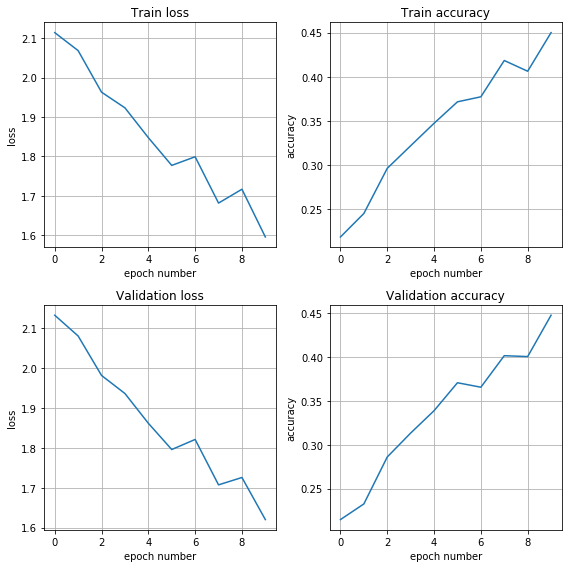

Current train loss: 1.595294
Current train accuracy: 0.450000
Current validation loss: 1.620286
Current validation accuracy: 0.447643
CPU times: user 5min 18s, sys: 3min 19s, total: 8min 38s
Wall time: 8min


In [6]:
for iteration_number, (loss, learning_rate, optimizer) in enumerate(itertools.product(train_losses, learning_rates, optimizers)):
    net = VGG(in_channels = in_channels, 
            out_channels = out_channels,
            conv_blocks_out_size = [64,128,256,512,512],
            conv_blocks_amounts = [2,2,2,2,2],
            linear_layers_out_size = [200,200,out_channels])
    net.to(device)
    
    loss = loss()
    optimizer = optimizer(net.parameters(), lr=learning_rate)
    
    info_to_show = f"Config {iteration_number+1}/{len(train_losses)*len(learning_rates)*len(optimizers)}:\n Loss: {loss.__class__},\nLearning_rate: {learning_rate},\nOptimizer: {optimizer}"
    %time net, best_val_loss, best_val_acc, best_train_loss, best_train_acc = train(net, optimizer, loss, epoch_num, trainloader, valloader, device, info_to_show)
    validation_info.append([iteration_number+1, loss, learning_rate, optimizer, best_val_loss, best_val_acc, best_train_loss, best_train_acc])
    
    with torch.no_grad():
        torch.save({"model_instance" : net,
                    "loss function" : loss,
                    "learning_rate": learning_rate,
                    "optimizer": optimizer},
                   LOG_PATH+f"model_{iteration_number+1}", 
                   pickle_module=dill)
    

In [7]:
res = pd.DataFrame(validation_info, columns=["model_number", "loss", "learning_rate", "optimizer", "best_val_loss", "best_val_acc", "best_train_loss", "best_train_acc"])

In [8]:
res

,model_number,loss,learning_rate,optimizer,best_val_loss,best_val_acc,best_train_loss,best_train_acc
0,1,CrossEntropyLoss(),0.00010,"Adam (\nParameter Group 0\n amsgrad: False\n betas: (0.9, 0.999)\n eps: 1e-08\n lr: 0.0001\n weight_decay: 0\n)",1.008826,0.673121,0.885751,0.705285
1,2,CrossEntropyLoss(),0.00001,"Adam (\nParameter Group 0\n amsgrad: False\n betas: (0.9, 0.999)\n eps: 1e-08\n lr: 1e-05\n weight_decay: 0\n)",1.620286,0.447643,1.595294,0.450000


In [9]:
res.loc[res["best_val_acc"]==max(res["best_val_acc"])]

,model_number,loss,learning_rate,optimizer,best_val_loss,best_val_acc,best_train_loss,best_train_acc
0,1,CrossEntropyLoss(),0.0001,"Adam (\nParameter Group 0\n amsgrad: False\n betas: (0.9, 0.999)\n eps: 1e-08\n lr: 0.0001\n weight_decay: 0\n)",1.008826,0.673121,0.885751,0.705285
